In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pylab as plt
import torch
import time
import sys

sys.path.insert(0, '../code') 
from network import UNet
from model_loader_func import load_UNet
from plotting_func import plot_many_denoised,  show_im_set, plot_single_im
from quality_metrics_func import calc_psnr, im_set_corr
from linear_approx import calc_jacobian, traj_projections
from inverse_tasks_func import synthesis
from algorithm_inv_prob import univ_inv_sol, competing_inv_sol
from dataloader_func import add_noise_torch

%matplotlib inline

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [3]:
## Load pretraiend denoisers 

denoisers_face = {}
# denoisers in group A are trained on one partision of the data which is non-overlapping with partision B
groups = ['A', 'B'] 
swap = False
training_data_name = 'img_align_celeba_80x80'

Ns = [1,10,100,1000, 10000,99325] #size of the dataset 

for group in groups: 
    print('loading group ' , group )
    denoisers_face[group] = {}
    if group == 'B': 
        swap = True
    for N in Ns:       
        start_time_total = time.time()        
        try: 
            denoisers_face[group][N] = load_UNet(
                           base_path = '../denoisers/UNet',
                           training_data_name= training_data_name, 
                           training_noise='0to255',
                           RF=90,
                           set_size=N, 
                           swap=swap);
        except FileNotFoundError: 
            pass 
        print("--- %s seconds ---" % (round(time.time() - start_time_total)))

loading group  A
--- 1 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
loading group  B
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---
--- 0 seconds ---


In [4]:
denoisers_face['A'].keys()

dict_keys([1, 10, 100, 1000, 10000, 99325])

In [5]:
###### Before running this cell, down the dataset from ??? into the datasets/img_align_celeba/ folder.
###### Dataset consist of CelebA images cropped to 160x160 and then downsampled to 80x80.
###### The RGB channels have been averaged to create grayscale images 

train_face ={}
test_face = {}
train_face['A'] = {}
train_face['B'] ={}
test_face['B'] = {}
test_face['A'] = {}

Ns = [1,10,100,1000, 10000,99325]

data = torch.load('/mnt/ceph/users/dlipshutz/datasets/celeb-faces/train80x80_no_repeats.pt')
K = data.shape[2] 
print(data.shape)
for N in Ns:
    train_face['A'][N] = data[0:N]
    test_face['A'][N] = data[-N::]
    train_face['B'][N] = data[-N::]
    test_face['B'][N] = data[0:N]   

torch.Size([198650, 1, 80, 80])


In [6]:
## rename N=99325 with N=100000 for ease of use later 
## Do not run this cell twice! 

denoisers_face['A'][100000] = denoisers_face['A'][99325]
del denoisers_face['A'][99325]   
denoisers_face['B'][100000] = denoisers_face['B'][99325]
del denoisers_face['B'][99325]  

train_face['A'][100000] = train_face['A'][99325]
del train_face['A'][99325]   
train_face['B'][100000] = train_face['B'][99325]
del train_face['B'][99325]  

test_face['A'][100000] = test_face['A'][99325]
del test_face['A'][99325]   
test_face['B'][100000] = test_face['B'][99325]
del test_face['B'][99325] 

Ns = list(denoisers_face['A'].keys())
print(Ns)

[1, 10, 100, 1000, 10000, 100000]


# Synthesis

In [9]:
synth = synthesis() 
samples_faces = {}
all_interm_Ys = {}
seed = 0
for group in groups: 
    samples_faces[group] = {}
    all_interm_Ys[group] = {}
    for N in Ns: 
        torch.manual_seed(seed)
        sample, interm_Ys, all_sigs, all_means = univ_inv_sol(denoisers_face[group][N], 
                                                             x_c= torch.zeros(1,K,K).cuda(),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01 , 
                                                             beta=.1 , 
                                                             freq=0,
                                                             seed = seed, 
                                                             init_im = train_face[group][N].mean(dim=0).cuda()+ torch.randn(1,K,K, device = device), 
                                                             init_noise_mean=0,
                                                             max_T=2000, 
                                                             fixed_h=False)

        samples_faces[group][N] = sample.detach()
        all_interm_Ys[group][N] = interm_Ys

-------- final sigma,  0.09644220024347305
-------- final mean  0.7135465741157532
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0031
-------- final sigma,  0.09800808876752853
-------- final mean  0.22324338555335999
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0022
-------- final sigma,  0.09800226986408234
-------- final mean  0.3222373127937317
-------- total number of iterations,  86 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.09816739708185196
-------- final mean  0.44724535942077637
-------- total number of iterations,  84 -------- average time per iteration (s),  0.0022
-------- final sigma,  0.09749320894479752
-------- final mean  0.46044525504112244
-------- total number of iterations,  77 -------- average time per iteration (s),  0.0021
-------- final sigma,  0.09668297320604324
-------- final mean  0.4606708884239197
-------- total number of iterations,  76 --------

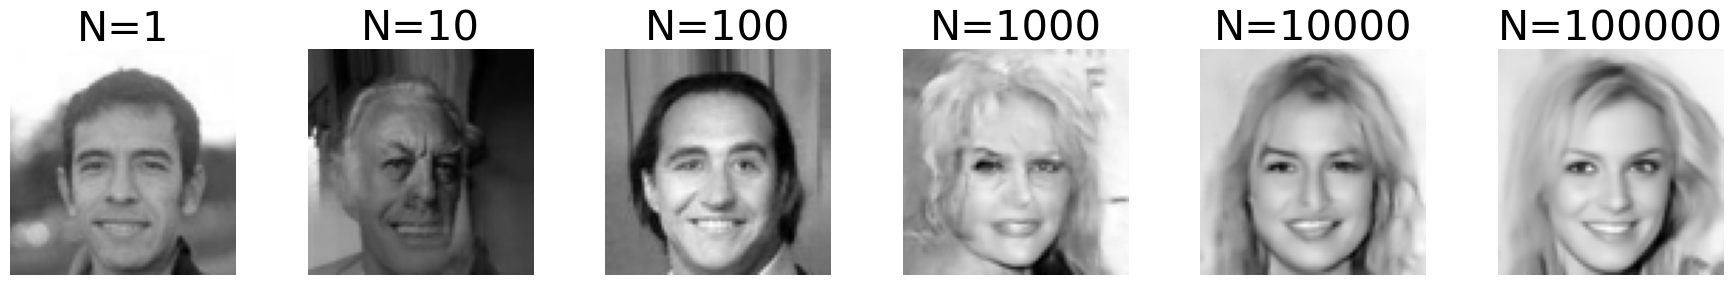

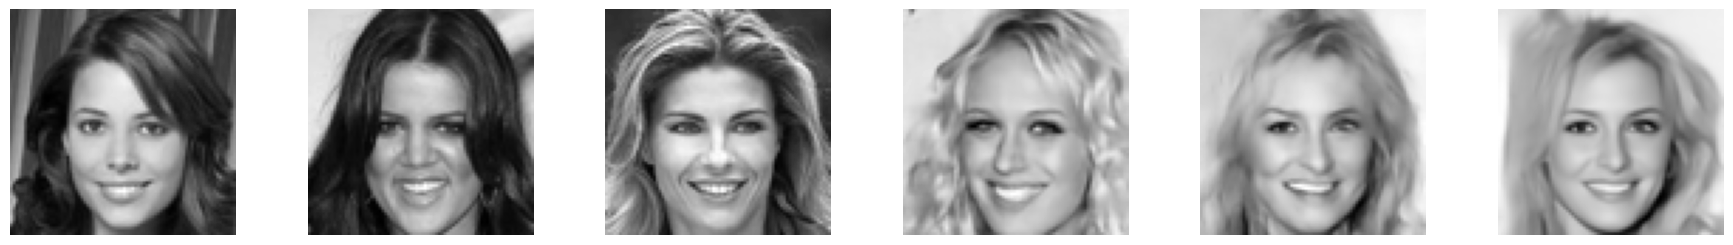

In [10]:
group = 'A'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=6)
group = 'B'
show_im_set(torch.stack([v for k, v in samples_faces[group].items()]), label='',sub_labels= ['']*6 , n_columns=6)

# Synthesis by competition

In [42]:
synth = synthesis() 
samples_faces = {}
all_interm_Ys = {}
seed = 0

samples_faces = {}
all_interm_Ys = {}
theta_list = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
for theta in theta_list:
    samples_faces[theta] = {}
    all_interm_Ys[theta] = {}
    for N in Ns: 
        torch.manual_seed(seed)
        sample, interm_Ys, all_sigs, all_means = competing_inv_sol(denoisers_face[groups[0]][N],
                                                             denoisers_face[groups[1]][N],
                                                             theta = theta,
                                                             x_c= torch.zeros(1,K,K).cuda(),
                                                             task=synth,
                                                             device=device,
                                                             sig_0=1, 
                                                             sig_L=.1, 
                                                             h0=.01,
                                                             beta=.1,
                                                             freq=0,
                                                             seed = seed,
                                                             init_im = train_face[group][N].mean(dim=0).cuda()+ torch.randn(1,K,K, device = device),
                                                             init_noise_mean=0,
                                                             max_T=2000,
                                                             fixed_h=False)
    
        samples_faces[theta][N] = sample.detach()
        all_interm_Ys[theta][N] = interm_Ys

not converging
-------- final sigma,  2.032489061355591
-------- final mean  0.27100878953933716
-------- total number of iterations,  10 -------- average time per iteration (s),  0.0038
not converging
-------- final sigma,  2.1634461879730225
-------- final mean  0.3100655674934387
-------- total number of iterations,  10 -------- average time per iteration (s),  0.0037
not converging
-------- final sigma,  2.0360751152038574
-------- final mean  0.44300761818885803
-------- total number of iterations,  10 -------- average time per iteration (s),  0.0037
not converging
-------- final sigma,  2.014864683151245
-------- final mean  0.4191912114620209
-------- total number of iterations,  10 -------- average time per iteration (s),  0.0037
not converging
-------- final sigma,  2.2774665355682373
-------- final mean  0.43292343616485596
-------- total number of iterations,  11 -------- average time per iteration (s),  0.0038
not converging
-------- final sigma,  2.0105206966400146
-------

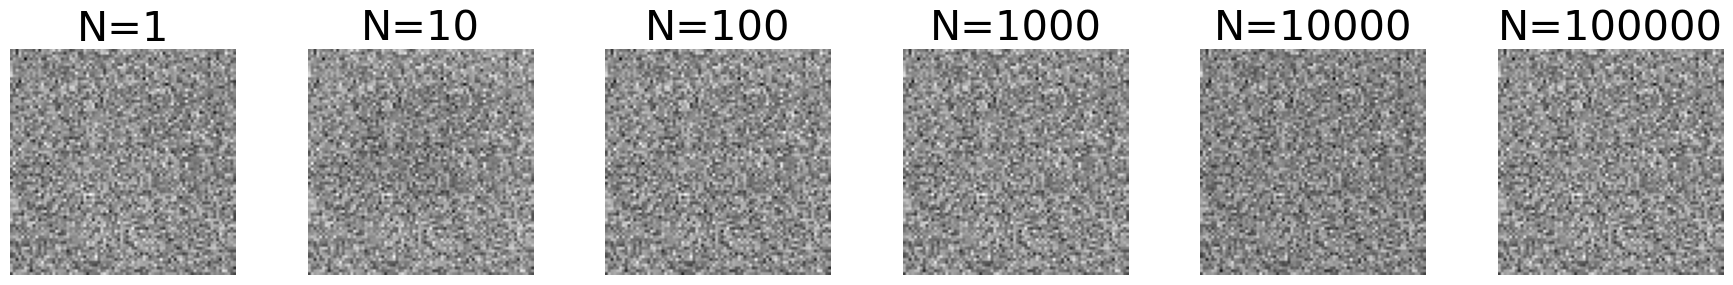

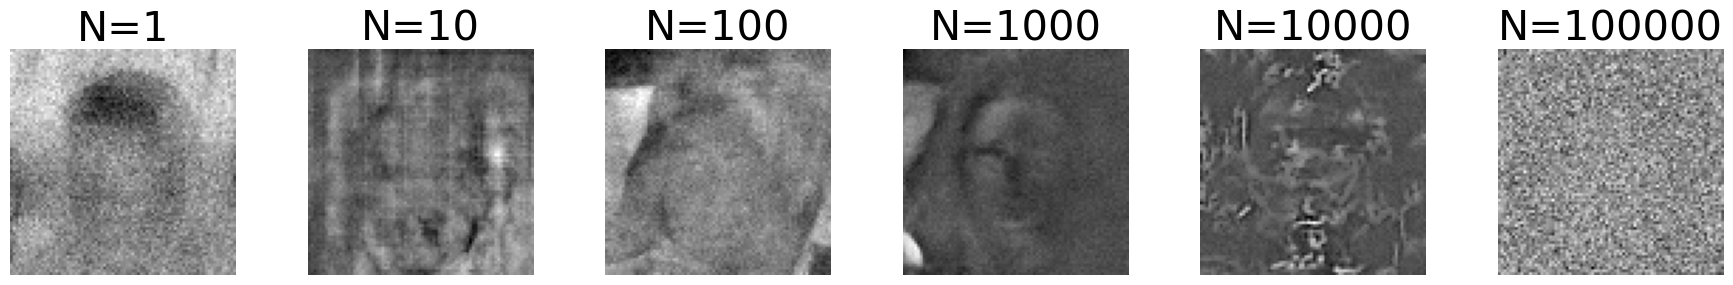

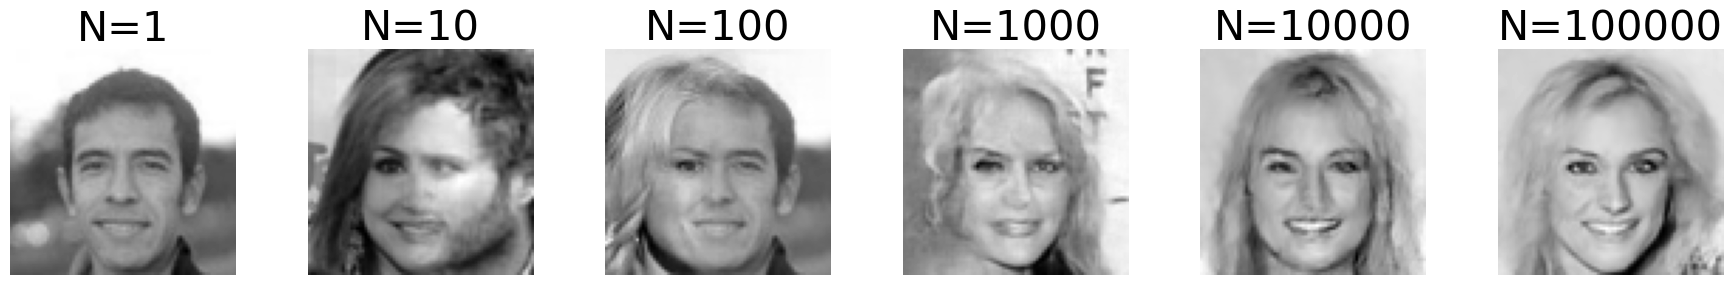

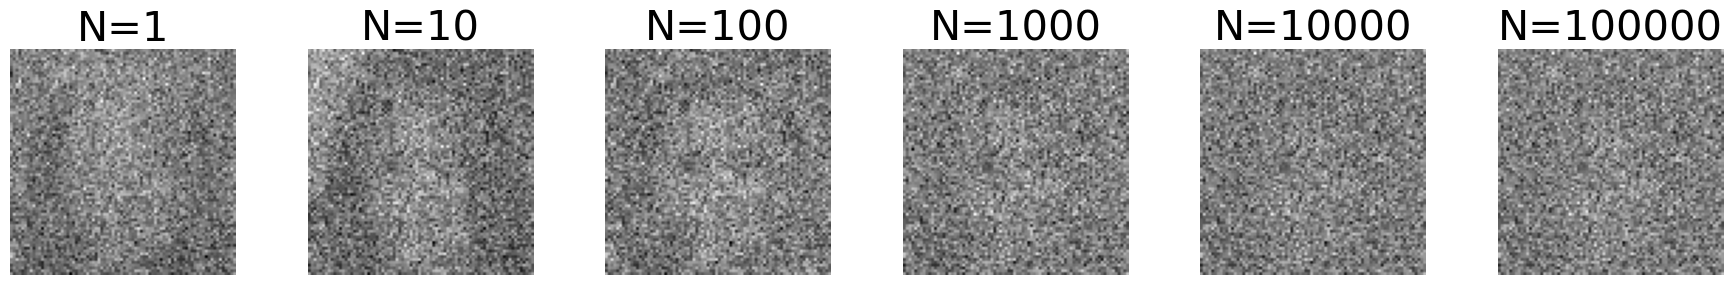

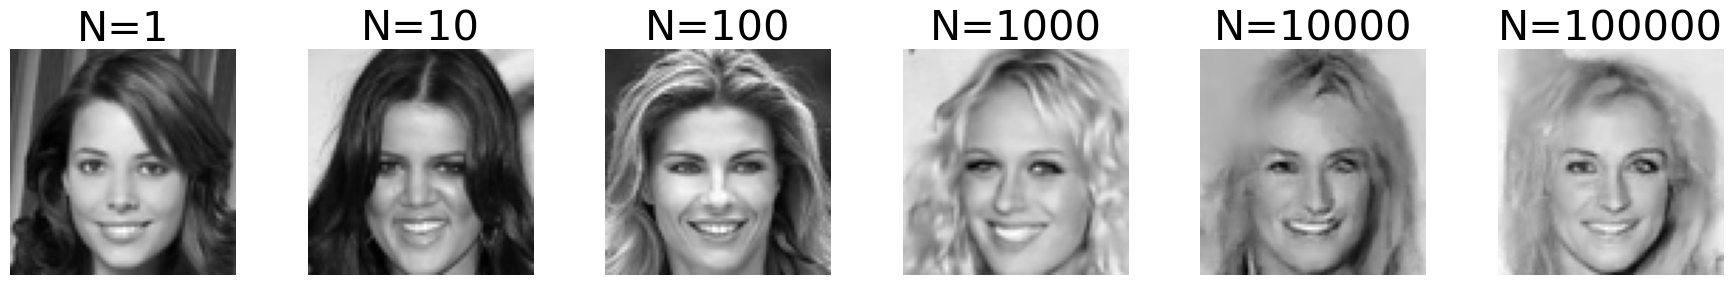

In [43]:
for theta in theta_list:
    show_im_set(torch.stack([v for k, v in samples_faces[theta].items()]), label='',sub_labels= ['N='+str(N) for N in denoisers_face[group].keys()] , n_columns=6)